In [54]:
import pandas as pd
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import pandas as pd
import copy

df = pd.read_csv('comparison.csv')
df2 = pd.read_csv('hashtags-akira.csv', header=None)
df3 = pd.read_csv('hashtags-acquila.csv', header=None)
df.head()

,hashtag,gpt2_segmentation,heuristics_segmentation,edit_distance
0,USA,usa,us a,1
1,NYC,nyc,ny c,1
2,ISC,isc,is c,1
3,BETA,beta,be ta,1
4,Havana,havana,havan a,1


In [2]:
df2.head()

,0
0,USA
1,NYC
2,ISC
3,BETA
4,Havana


In [3]:
df3.head()

,0
0,USA
1,NYC
2,ISC
3,BETA
4,Havana


In [4]:
df2['hashtag'] = df2[0].str.replace(" ", "")
merged_df = df.merge(df2, on='hashtag')

df3.rename(columns={
    0: 1
}, inplace=True)
df3['hashtag'] = df3[1].str.replace(" ", "")
merged_df = merged_df.merge(df3, on='hashtag')

In [5]:
merged_df.head()

,hashtag,gpt2_segmentation,heuristics_segmentation,edit_distance,0,1
0,USA,usa,us a,1,USA,USA
1,NYC,nyc,ny c,1,NYC,NYC
2,ISC,isc,is c,1,ISC,ISC
3,BETA,beta,be ta,1,BETA,BETA
4,Havana,havana,havan a,1,Havana,Havana


1         AxesSubplot(0.1,0.15;0.114286x0.75)
2    AxesSubplot(0.237143,0.15;0.114286x0.75)
3    AxesSubplot(0.374286,0.15;0.114286x0.75)
4    AxesSubplot(0.511429,0.15;0.114286x0.75)
5    AxesSubplot(0.648571,0.15;0.114286x0.75)
dtype: object

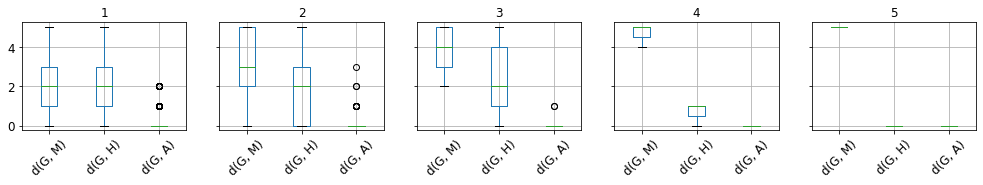

In [6]:
df = merged_df


df.rename(columns={
    0: 'gold',
    1: 'human'
}, inplace=True)

import editdistance
df['gpt2_heu_distance'] = df['gpt2_segmentation'].combine(df['heuristics_segmentation'], editdistance.eval)
df['gpt2_gold_distance'] = df['heuristics_segmentation'].combine(df['gold'], editdistance.eval)
df['heu_gold_distance'] = df['gpt2_segmentation'].combine(df['gold'], editdistance.eval)
df['human_gold_distance'] = df['human'].combine(df['gold'], editdistance.eval)

original_df = copy.deepcopy(df)

df = df[['gpt2_heu_distance', 'gpt2_gold_distance', 'heu_gold_distance', 'human_gold_distance']]
import numpy as np

df = df.astype(int)
for item in ['gpt2_heu_distance', 'gpt2_gold_distance', 'heu_gold_distance']:
    df[item] = df[item].apply(lambda x: 5 if x > 5 else x)

df = df.rename(columns={
    "gpt2_heu_distance": "d(M, H)",
    "gpt2_gold_distance": "d(G, M)",
    "heu_gold_distance": "d(G, H)",
    "human_gold_distance": "d(G, A)"
})

plot = df.set_index("d(M, H)").groupby("d(M, H)").boxplot(layout=(1,6), rot=45, fontsize=12, figsize=(20,2))

plot

In [7]:
df = merged_df


df.rename(columns={
    0: 'gold',
    1: 'human'
}, inplace=True)

df = df[['human_gold_distance', 'human', 'gold']]
df = df[df['human_gold_distance'] > 0]
pd.set_option('display.max_rows', 200)
df = df.sort_values('human_gold_distance').groupby('human_gold_distance').head(100)
df = df[['human', 'gold']]
df = df.rename(columns={
    "human": "acquila",
    "gold": "akira"
})

df.to_csv('acquila_akira_comparacao.tsv', index=False, sep='\t')

In [8]:
df.shape

(100, 2)

In [31]:
df = original_df.applymap(lambda x: x.lower() if isinstance(x, str) else x )

hashtags = {
    'gold' : df['gold'].values.tolist(),
    'human' : df['human'].values.tolist(),
    'model' : df['gpt2_segmentation'].values.tolist(),
    'heuristics' : df['heuristics_segmentation'].values.tolist()
}

In [21]:
import json
import string

def get_from_dict(dct, *keys):
    for key in keys:
        dct = dct[key]
    return dct

def get_category(char):
    if not char.strip():
        return "SPACE"
    elif char in string.punctuation:
        return "PUNCT"
    else:
        return "CHAR"

class DFA(object):

    def __init__(self, filename, initial_state='s0', chars=['B', 'M', 'E', 'S']):
        with open(filename,'r') as f:
            self.dfa = json.load(f)
        self.initial_state = initial_state
        self.chars = chars

    def run_DFA(self, string_input):
        state = self.initial_state
        output = ''
        if not any(string_input.endswith(x) for x in string.punctuation):
            string_input += '.'
        for char in string_input:
            category = get_category(char)
            state = get_from_dict(self.dfa, state, category)
            output += state
        output = [ x for x in output if x in self.chars]
        return output

In [84]:
dfa = DFA('dfa.json')

labels = defaultdict(list)
for key in hashtags.keys():
    label_key = key + '_labels'
    for hashtag in hashtags[key]:
        dfa_output = dfa.run_DFA(hashtag)
        labels[label_key].extend(dfa_output)

from sklearn.metrics import cohen_kappa_score
import itertools

annotator_pairs = list(itertools.permutations(labels.keys(), 2))

kappa_df = []

label_dict = {
    "heuristics_labels": "Heuristics",
    "human_labels": "Human",
    "model_labels": "GPT-2",
    "gold_labels": "Gold standard"
}

for pair in annotator_pairs:
    a = labels[pair[0]]
    b = labels[pair[1]]
    row = {
        "Annotator A": label_dict[pair[0]],
        "Annotator B": label_dict[pair[1]],
        "kappa": cohen_kappa_score(a,b)
    }
    kappa_df.append(row)

kappa_df = pd.DataFrame(kappa_df)
kappa_df = kappa_df.pivot(index='Annotator A', columns='Annotator B', values='kappa').fillna(1.0).round(3)


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(kappa_df, dtype=bool))

kappa_output_df = kappa_df.where(~mask).dropna(how='all').fillna(" ")
kappa_output_df

Annotator B,GPT-2,Gold standard,Heuristics,Human
Annotator A,,,,
Gold standard,0.898,,,
Heuristics,0.601,0.679,,
Human,0.897,0.969,0.682,


In [85]:
print(kappa_output_df.to_latex())

\begin{tabular}{lrlll}
\toprule
Annotator B &  GPT-2 & Gold standard & Heuristics & Human \\
Annotator A   &        &               &            &       \\
\midrule
Gold standard &  0.898 &               &            &       \\
Heuristics    &  0.601 &         0.679 &            &       \\
Human         &  0.897 &         0.969 &      0.682 &       \\
\bottomrule
\end{tabular}

